# 1. Импортирование библиотек и модулей

In [18]:
import numpy as np
import pandas as pd
import joblib
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import shap
from sklearn.preprocessing import StandardScaler

# 2.Загрузка обучающей и тестовой выборок

In [19]:
fname_tr = "datasets/HDAC6_ws.sdf"

mols_tr = []
y_tr = []
for mol in Chem.SDMolSupplier(fname_tr):
    if mol is not None:
        mols_tr.append(mol)
        y_tr.append(mol.GetIntProp("Active"))

In [20]:
fname_ts = "datasets/HDAC6_ts.sdf"

mols_ts = []
y_ts = []
for mol in Chem.SDMolSupplier(fname_ts):
    if mol is not None:
        mols_ts.append(mol)
        y_ts.append(mol.GetIntProp("Active"))

# 3.Расчет дескрипторов обучающей выборки

In [21]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = calc.GetDescriptorNames()

In [22]:
descr_tr= []
for m in mols_tr:
    descr_tr.append(calc.CalcDescriptors(m))
x_tr = np.asarray(descr_tr)

In [23]:
df_RDKit_2D_ws = pd.DataFrame(x_tr,columns=header)

In [24]:
df_RDKit_2D_ws.head(2)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.330332,-0.593978,12.330332,0.044291,0.366637,302.374,280.198,302.163043,118.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.715980,-3.663292,12.715980,0.213972,0.432827,342.376,328.264,342.067428,122.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
x_tr.shape

(105, 208)

In [26]:
descriptors_list = [x[0] for x in Descriptors._descList]
print(descriptors_list)
len(descriptors_list)

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

208

In [27]:
df_RDKit_2D_ws.to_csv('matrix_descriptors.csv')

# 4. Расчет дескрипторов тестовой выборки

In [28]:
descr_ts = []
for m in mols_ts:
    descr_ts.append(calc.CalcDescriptors(m))
x_ts = np.asarray(descr_ts)

In [29]:
df_RDKit_2D_ts = pd.DataFrame(x_ts,columns=header)

In [30]:
df_RDKit_2D_ts.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.223132,-0.378519,12.223132,0.048339,0.155734,533.370,509.178,533.092388,162.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
1,11.030329,-0.333689,11.030329,0.333689,0.100283,480.572,452.348,480.227374,182.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,12.217763,-0.369075,12.217763,0.022119,0.306665,413.522,382.274,413.242690,162.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,10.969457,-0.538595,10.969457,0.538595,0.228672,349.434,326.250,349.179027,134.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,11.946330,-0.364173,11.946330,0.000521,0.364607,340.423,316.231,340.178693,132.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [31]:
x_ts.shape

(26, 208)

# 5. Загрузка модели RF

In [32]:
best_clf_RF = joblib.load("models/HDAC6_RF_RDKit_2D.pkl")
best_clf_GBM = joblib.load("models/HDAC6_GBM_RDKit_2D.pkl")
best_clf_SVM = joblib.load("models/HDAC6_SVM_RDKit_2D.pkl")

# 6. Анализ важности дескрипторов

## 6.1. Анализ важности дескрипторов для модели RF

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Using 105 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/26 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

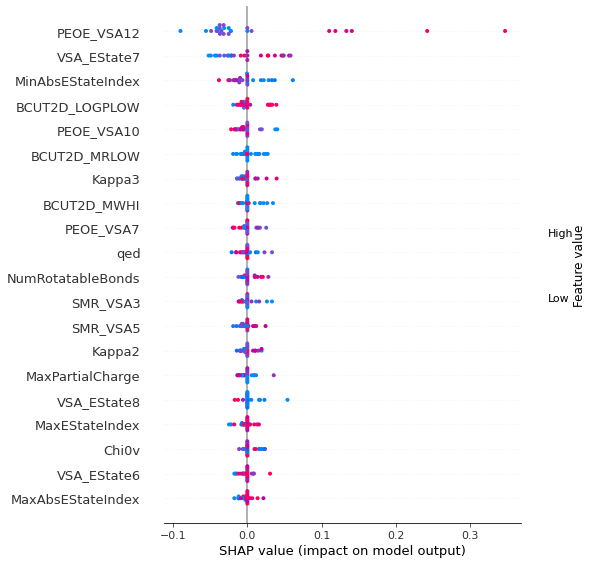

In [33]:
explainer = shap.KernelExplainer(best_clf_RF.predict, df_RDKit_2D_ws)
shap_values = explainer.shap_values(df_RDKit_2D_ts)
shap.summary_plot(shap_values, df_RDKit_2D_ts)

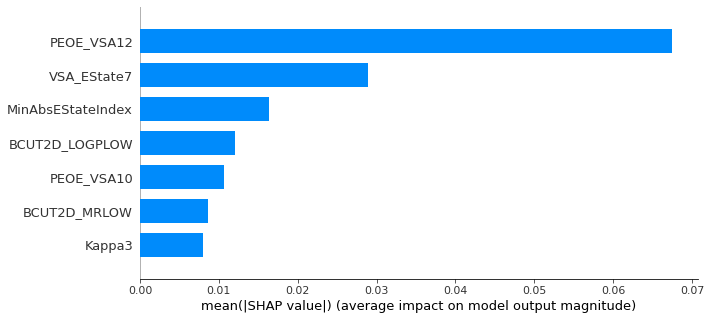

In [34]:
shap.summary_plot(shap_values, df_RDKit_2D_ts, plot_type="bar", plot_size=(10,5), max_display=7)

## 6.2. Анализ важности дескрипторов для модели GBM

In [35]:
explainer_GBM = shap.KernelExplainer(best_clf_GBM.predict, df_RDKit_2D_ws)
shap_values_GBM = explainer_GBM.shap_values(df_RDKit_2D_ts)

Using 105 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/26 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

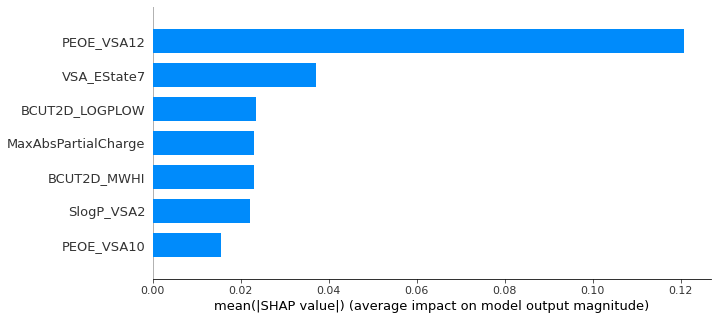

In [36]:
shap.summary_plot(shap_values_GBM, df_RDKit_2D_ts, plot_type="bar", plot_size=(10,5), max_display=7)

## 6.3. Анализ важности дескрипторов для модели SVM

In [37]:
sc = StandardScaler()
X_train_norm = sc.fit_transform(df_RDKit_2D_ws)

X_test_norm = sc.transform(df_RDKit_2D_ts)

In [38]:
df_RDKit_2D_ws_norm = pd.DataFrame(X_train_norm,columns=header)
df_RDKit_2D_ts_norm = pd.DataFrame(X_test_norm,columns=header)

In [39]:
df_RDKit_2D_ws_norm.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.044319,0.237386,0.044319,-1.118949,0.692153,-1.518600,-1.583330,-1.518449,-1.367513,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,-0.960420,-0.098058
1,0.435200,-2.636930,0.435200,0.376555,1.289981,-0.968535,-0.896117,-0.968844,-1.216684,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,-0.960420,-0.098058
2,1.176493,0.128056,1.176493,-0.359798,-0.367236,0.421380,0.419319,0.423742,0.517845,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,1.231843,-0.098058
3,-0.010563,0.421855,-0.010563,-0.703493,-1.209326,0.752392,0.677013,0.754846,0.970331,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,1.231843,-0.098058
4,-0.074057,0.434755,-0.074057,-0.985227,-1.072010,0.133092,0.076341,0.134918,0.291602,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,1.231843,-0.098058


In [40]:
df_RDKit_2D_ts_norm.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.064335,0.439157,-0.064335,-1.083272,-1.212738,1.657807,1.690462,1.662153,0.291602,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,1.231843,-0.098058
1,-1.273323,0.481138,-1.273323,1.431703,-1.713582,0.931786,0.877947,0.934040,1.045745,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,1.231843,-0.098058
2,-0.069777,0.448000,-0.069777,-1.314362,0.150474,0.009787,-0.123921,0.011457,0.291602,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,1.231843,-0.098058
3,-1.335022,0.289251,-1.335022,3.237670,-0.553965,-0.871481,-0.924912,-0.870895,-0.764198,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,-0.229666,-0.098058
4,-0.344893,0.452591,-0.344893,-1.504724,0.673818,-0.995391,-1.068156,-0.994857,-0.839613,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.199007,0.0,0.0,1.231843,-0.098058


In [41]:
explainer_SVM = shap.KernelExplainer(best_clf_SVM.predict, df_RDKit_2D_ws_norm)
shap_values_SVM = explainer_SVM.shap_values(df_RDKit_2D_ts_norm)

Using 105 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/26 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

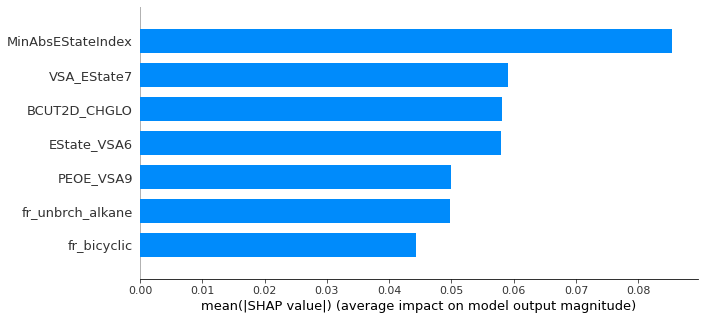

In [42]:
shap.summary_plot(shap_values_SVM, df_RDKit_2D_ts_norm, plot_type="bar", plot_size=(10,5), max_display=7)